In [1]:
pip install open3d

In [ ]:
import open3d

In [ ]:
pip install transformers

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/glpn/feature_extraction_glpn.py:30: FutureWarning: The class GLPNFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use GLPNImageProcessor instead.
  warnings.warn(


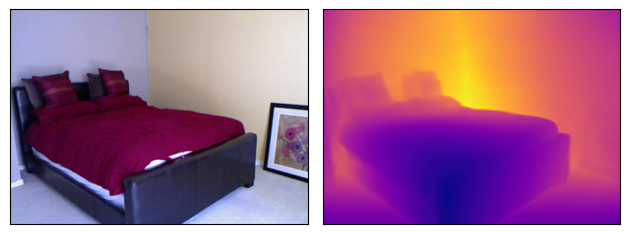

In [3]:
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import torch
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation

feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

# load and resize the input image
image = Image.open("bed.png")
new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32
new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image = image.resize(new_size)

# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

# get the prediction from the model
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# remove borders
pad = 16
output = predicted_depth.squeeze().cpu().numpy() * 1000.0
output = output[pad:-pad, pad:-pad]
image = image.crop((pad, pad, image.width - pad, image.height - pad))

# visualize the prediction
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].imshow(output, cmap='plasma')
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.pause(5)

In [4]:
import numpy as np
import open3d as o3d

width, height = image.size

depth_image = (output * 255 / np.max(output)).astype('uint8')
image = np.array(image)

# create rgbd image
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)

# camera settings
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width/2, height/2)

# create point cloud
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)


In [6]:
pcd

PointCloud with 239616 points.

In [7]:
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [8]:
# outliers removal
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=20.0)
pcd = pcd.select_by_index(ind)

# estimate normals
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

# surface reconstruction
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1)[0]

# rotate the mesh
rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center=(0, 0, 0))

# save the mesh
o3d.io.write_triangle_mesh(f'./mesh.obj', mesh)

True